# Fighting California forest fires using spatial analysis

The state of California has had a dangerous fire season in 2015 and 2016. A standard procedure while fighting these fires is identifying facilities that are at risk and evacuating them. Tasks such as this can be accomplished easily using **spatial analysis** tools available on your GIS. Spatial analysis tools allow overlaying the extent of fire and the locations of the facilities on a map and identifying the ones that fall within the fire's extent.

Thus, this sample demonstrates the application of spatial analysis tools such as **buffer and overlay**.

This notebook describes a scenario wherein an analyst automates the process of identifying facilities at risk from forest fires and sharing this information with other departments such as the fire department, etc.

**Note**: To run this sample, you need the ``pandas`` library in your conda environment. If you don't have the library, install it by running the following command from cmd.exe or your shell
```
conda install pandas```

In [ ]:
import datetime
import arcgis
from arcgis.gis import GIS
from IPython.display import display
import pandas as pd

# create a Web GIS object
gis = GIS("https://python.playground.esri.com/portal", "arcgis_python", "amazing_arcgis_123")

## Using groups to share items and collaborate

A group effort spanning several professionals and teams is required to meet challenges such as forest fires. Members of a web GIS can collaborate with each other by sharing web maps, layers, applications, etc. with each other. This sharing is accomplished by creating groups in the GIS and items shared to a group can be used by members of the group.

The code below lists the items shared with the 'LA County Emergency Management' group. This group contains a collection of maps, apps and layers that are published as the authoritative common map for the county of Los Angeles.

<Group title:"LA County Emergency Management" owner:arcgis_python>
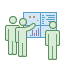

In [ ]:
# get our group
group = gis.groups.search('LA County Emergency Management')[0]
group

<Item title:"Active California Fires" type:Feature Service owner:arcgis_python>
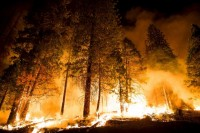

<Item title:"Critical Infrastructure in Southern California" type:Feature Service owner:arcgis_python>
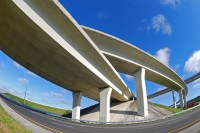

<Item title:"LA County Infrastructure at Risk" type:Web Map owner:arcgis_python>
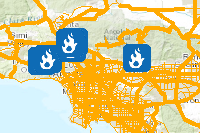

In [ ]:
# list items in the group
items = group.content()
for item in items: 
    display(item)

## Visualize the fire data
Let us create a map widget to see the fire related information in it's geographic context:

In [ ]:
# create a map of our area of interest
m = gis.map('Los Angeles', 9)
m

![m](http://esri.github.io/arcgis-python-api/notebooks/nbimages/04_CA_fires_01.PNG)

In [ ]:
# add the active fires layer
fires = items[0]
m.add_layer(fires)

In [ ]:
# add our critical infrastructure layer
infra = items[1]
m.add_layer(infra)

In [ ]:
#we shall use this webmap item in the last section of the notebook.
webmapitem = items[2]

The `fires` feature layer, that we just added to the map, contains the boundaries of the active forest fires in the region. For this demo scenario, this layer is being constantly updated by the Fire Department with inputs from fire fighters in the field and remote sensing data obtained from satellites.

The `infra` feature layer contains the locations of critical infrastructure facilities in the region. The objective of this script is to identify critical infrastructure facilities that are at risk due to the fires, and alert firefighters, county officials and others for allocating firefighting resources, planning evacuations, etc.

## Create a buffer of 4 miles around fire boundaries

To identify the critical infrastructure resources that are the risk, let us create a buffer of 4 miles around the fire boundaries and consider all facilities that fall within this area at risk. The process of buffer expands the feature's boundaries in all directions. 

To perform buffers, we use the **`create_buffers`** function available in the **`arcgis.features.use_proximity`** module.
As an input to the tool, we provide the fires layer as the layer to be buffered.

Feature analysis tools can return (in memory) feature collections as output for immediate consumption, or create a new feature service if the `output_name` parameter is specified.

We specify an output name (with a timestamp) for the service as we may want the buffered fire perimeters to be persisted for bookkeeping purposes, or be shared with others as feature layers or in web maps:

In [ ]:
# create a map of our area of interest
m1 = gis.map('Los Angeles', 9)
m1

![m1](http://esri.github.io/arcgis-python-api/notebooks/nbimages/04_CA_fires_02.PNG)

In [ ]:
#add the active fires layer to the map
m1.add_layer(fires)

In [ ]:
#add the critical infrastructure layer to the map
m1.add_layer(infra)

In [ ]:
from arcgis.features.use_proximity import create_buffers

# buffer the active fire boundaries and add as new content

timestamp = '{:%Y_%m_%d_%H_%M_%S}'.format(datetime.datetime.now())
firebuffers = create_buffers(fires, [4], None, 'Miles', output_name="Fire_Buffers_" + timestamp )

The output layer is private by default. To share it with particular groups, members within the org,  or everyone, we can use the `Item.share()` method. The code below shares it to everyone (public):

In [ ]:
# share the layer with public
firebuffers.share(True)

{'itemId': '9c0e5f55f6d740b9a04c32da3f326468', 'notSharedWith': []}

Since the `output_name` parameter was specified, the tool created a new feature layer item as output. We can visualize this by adding it to the map above. Now we can observe more facilities falling within the buffered area.

In [ ]:
# add risk areas to map
m1.add_layer(firebuffers)

## Perform overlay analysis to extract facilities that fall within the fire buffers

To programmatically extract the locations that fall within the fire buffers, we use **`overlay_layers`** tool under `FeatureAnalysisTools` class just like we did for `create_buffers` tool earlier. The `overlay_layers` tool supports a few overlay types, here we use **`Intersect`** as we need to perform a spatial intersection to identify the facilities that are located within the fire boundaries. To learn more about this operation, refer to the [documentation](https://developers.arcgis.com/rest/analysis/api-reference/overlay-layers.htm).

We specify an output name (with a timestamp) for the service as we want to keep a record of the critical infrastructure within the risk boundaries and share it with others as feature layers or in web maps:

In [ ]:
from arcgis.features.manage_data import overlay_layers

# run analysis to determine critical infrastructure within the risk boundaries
riskinfra = overlay_layers(firebuffers, infra, 
                           
                        overlay_type="Intersect",
                        output_name="At_Risk_Infrastructure_" + timestamp)

In [ ]:
# set sharing on new analysis layer
riskinfra.share(True)

{'itemId': '24e2adb3923a4150b654932afedd66b1', 'notSharedWith': []}

The output of the overlay analysis is a Feature Layer Item. We can access the layers and tables in an Item represing GIS services using the `layers` and `tables` attributes. 

In [ ]:
riskinfra.layers

[<FeatureLayer url:"http://python.playground.esri.com/server/rest/services/Hosted/At_Risk_Infrastructure_2017_06_27_10_26_24/FeatureServer/0">]

## Read analysis results as a pandas dataframe for analysis


Let us read this results of the overlay analysis by querying it's layer for attribute data, and display the attribute table to get a sense of the results. Layers can be queried for attributes and geometry using the `query()` method.

The query we ran in the previous step returned a list of dictionaries representing the features. For further analysis or for visualizing the output data as a table, let us convert it into a [pandas](http://pandas.pydata.org/) [dataframe](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.html).

In [ ]:
at_risk_facilities  = riskinfra.layers[0]
features = at_risk_facilities.query()

df = features.df # read the returned features as a Pandas dataframe
df

,acres,addrln1,addrln2,analysisarea,buff_dist,cat1,cat2,cat3,city,containmen,...,point_y,post_id,source,state,status,target_fid,url,use_type,zip,SHAPE
0,10850,,,112.459570,4.0,Physical Features,Power Plants,,,0.50,...,1.886700e+06,24626.0,HSIP Freedom Gnis_cultural_fe,,Active,15,,publish,,"{'y': 4052549.6177999973, 'x': -13121451.6931}"
1,1080,,,57.433120,4.0,Health and Mental Health,Hospitals and Medical Centers,,,0.65,...,1.880309e+06,26620.0,HSIP Freedom Gnis_structures,,Active,17,,publish,,"{'y': 4049970.820600003, 'x': -13206521.157200..."
2,8940,,,60.135539,4.0,Health and Mental Health,Hospitals and Medical Centers,,,0.80,...,1.924838e+06,27055.0,HSIP Freedom Gnis_structures,,Active,48,,publish,,"{'y': 4066587.2479000017, 'x': -13178369.5108}"
3,8940,12653 Osborne St.,,60.135539,4.0,Transportation,Airports,,Pacoima,0.80,...,1.916959e+06,13559.0,Current Services Locator,CA,Active,57,,publish,91331,"{'y': 4063657.5600000024, 'x': -13181708.85350..."
4,1080,5601 De Soto Ave.,,57.433120,4.0,Health and Mental Health,Hospitals and Medical Centers,911 Receiving,Woodland Hills,0.65,...,1.885131e+06,730.0,Current Services Locator,CA,Active,59,www.kaiserpermanente.org,publish,91365,"{'y': 4051785.356899999, 'x': -13201349.398400..."
5,8940,9449 San Fernando Rd.,,60.135539,4.0,Health and Mental Health,Hospitals and Medical Centers,911 Receiving,Sun Valley,0.80,...,1.910013e+06,637.0,211,CA,Active,166,www.pacificahospital.com,publish,91352,"{'y': 4061094.5309000015, 'x': -13179805.0937}"
6,8940,12756 Van Nuys Blvd,,60.135539,4.0,Health and Mental Health,Hospitals and Medical Centers,,Pacoima,0.80,...,1.922409e+06,70599.0,211,CA,Active,218,www.nevhc.org/,publish,91331,"{'y': 4065675.7991999984, 'x': -13181420.90529..."


From the data frame, we can see there are 7 features which fell within the fire buffers. To make this result usable, let us export a CSV with only the facility name and other critical details. This CSV can be considered as a valuable information product as a result of this analysis and can be shared with the teams assisting in organizing the firefighting efforts, evacuations, etc.

In [ ]:
# view simplified risk facilities table
df1_simplified = df[['name', 'cat1', 'post_id']]
df1_simplified

,name,cat1,post_id
0,Azusa Powerplant Conduit,Physical Features,24626.0
1,Motion Picture And Television Fund Hospital,Health and Mental Health,26620.0
2,Pacoima Memorial Hospital,Health and Mental Health,27055.0
3,Whiteman Airport,Transportation,13559.0
4,Kaiser Permanente - Woodland Hills Medical Center,Health and Mental Health,730.0
5,Pacifica Hospital Of The Valley,Health and Mental Health,637.0
6,Northeast Valley Health Corporation - Pacoima ...,Health and Mental Health,70599.0


In [ ]:
# Export this to a csv file. This CSV can then be shared with fire fighters.
csv_file = r'at_risk_facilities.csv'
df1_simplified.to_csv(csv_file)

## Mapping the infrastructure at risk

Tables and charts aren't enough to convey the information gathered from this analysis. By plotting the  locations of the critical infrastructure at risk from the forest fires, we are able to identify patterns that can be of great value in fighting a catastrophe of this scale and prevent or minimize human, infrastructural and environmental loss:

In [ ]:
# create new map over aoi
m2 = gis.map('Los Angeles', 9)
m2

![m2](http://esri.github.io/arcgis-python-api/notebooks/nbimages/04_CA_fires_04.PNG)

In [ ]:
#add the critical infrastructure layer to the map
m2.add_layer(infra)

In [ ]:
# add at risk facilities layer to fresh map
m2.add_layer(riskinfra)
             

## Sharing the result of the analysis as a web map

The different teams working on the firefighting, relief and rescue efforts need a current and updated web map of the critical infrastruture at risk from the fires. The code below fetches the web-map from the GIS and updates it's operational layer to the one from the analysis above. This enables all interested parties to refer to one common, constantly updated web-map for planning firefighting, rescue and relief efforts.

<Item title:"LA County Infrastructure at Risk" type:Web Map owner:arcgis_python>
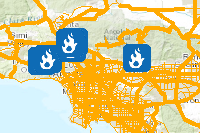

In [ ]:
#display the webmap item that we had obtained as part of the 'LA County Emergency Management' group's content in the first section of this notebook.
webmapitem

In [ ]:
# create a webmap from the item
webmap = arcgis.mapping.WebMap(webmapitem)

In [ ]:
# read the operational layers in our webmap
for lyr in webmap['operationalLayers']:
    if lyr['id'].startswith('At_Risk_Infrastructure'):
        print(lyr['url'])

http://services6.arcgis.com/SMX5BErCXLM7eDtY/arcgis/rest/services/At_Risk_Infrastructure_20170607_13_38_38/FeatureServer/0


In [ ]:
new_url = at_risk_facilities.url
new_url

'http://python.playground.esri.com/server/rest/services/Hosted/At_Risk_Infrastructure_2017_06_27_10_26_24/FeatureServer/0'

In [ ]:
# update the url of the 'At Risk Infrastructure' layer in the web map

for lyr in webmap['operationalLayers']:
    if lyr['id'].startswith('At_Risk_Infrastructure'):
        lyr['url'] = new_url

In [ ]:
# save the updates back to the GIS
webmap.update()

Web map items can also be visualized in the Jupyter Notebook as shown below. This enables use of web-maps for analysis and visualization within the notebook environment.

In [ ]:
#zoom in to the extents of Los Angeles in the map below, to view the webmapitem 
m3 = gis.map(webmapitem)
m3


![webmapitem](http://esri.github.io/arcgis-python-api/notebooks/nbimages/04_CA_fires_03.PNG)